In [ ]:
# This is for running the code in Google Colab
%cd /content
!git clone https://github.com/zwdconstrucition/TSPviaLLM.git
%cd /content/FunSearch-TSP

/content
Cloning into 'FunSearch-TSP'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (188/188), done.
remote: Total 206 (delta 26), reused 179 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (206/206), 2.32 MiB | 16.03 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/FunSearch-TSP


## 1-DataSet

In [1]:
!pip install tsplib95

In [2]:
import tsplib95
import pandas as pd
import matplotlib.pyplot as plt

import glob, os

import numpy as np
from itertools import chain
from scipy.spatial.distance import squareform, pdist
from functools import partial
import math

from typing import List

import random

In [ ]:
# edge_weight_type = []
# edge_weight_format = []

# for file in glob.glob("./data/*.tsp"):
#     problem = tsplib95.load(file)
#     if problem.edge_weight_type == 'EXPLICIT':
#         edge_weight_format.append(problem.edge_weight_format)
#     else:
#         edge_weight_type.append(problem.edge_weight_type)

# edge_weight_type = list(set(edge_weight_type))
# edge_weight_format = list(set(edge_weight_format))

# print(edge_weight_type)
# print(edge_weight_format)

In [3]:
class TSPProblem:
    def __init__(self, problem_path=None):
        problem = tsplib95.load(problem_path)
        self.name = problem.name
        self.dimension = problem.dimension

        if problem.edge_weight_type == 'EXPLICIT':
            # nodes
            self.nodes = pd.DataFrame.from_dict(problem.display_data, orient='index', columns=['x', 'y'])

            # distance matrix
            if problem.edge_weight_format == 'FULL_MATRIX':
                self.distance_matrix = problem.edge_weights
            else:
                if problem.edge_weight_format == 'LOWER_DIAG_ROW':
                    idx = np.tril_indices(self.dimension)
                if problem.edge_weight_format == 'UPPER_ROW':
                    idx = np.triu_indices(self.dimension, k=1)
                if problem.edge_weight_format == 'UPPER_DIAG_ROW':
                    idx = np.triu_indices(self.dimension)

                distance = list(chain(*problem.edge_weights))
                self.distance_matrix = np.zeros((self.dimension, self.dimension))
                self.distance_matrix[idx] = distance
                self.distance_matrix[idx[1], idx[0]] = distance
        else:
            # nodes
            self.nodes = pd.DataFrame.from_dict(problem.node_coords, orient='index', columns=['x', 'y'])

            # distance matrix
            if problem.edge_weight_type == 'EUC_2D':
                self.distance_matrix = squareform(pdist(self.nodes, tsplib95.distances.euclidean))
            if problem.edge_weight_type == 'CEIL_2D':
                self.distance_matrix = squareform(pdist(self.nodes, partial(tsplib95.distances.euclidean, round=math.ceil)))
            if problem.edge_weight_type == 'GEO':
                self.distance_matrix = squareform(pdist(self.nodes, tsplib95.distances.geographical))
            if problem.edge_weight_type == 'ATT':
                self.distance_matrix = squareform(pdist(self.nodes, tsplib95.distances.pseudo_euclidean))

        self.distance_matrix = pd.DataFrame(self.distance_matrix, index=range(1, self.dimension+1), columns=range(1, self.dimension+1))

        # opt
        opt_path = os.path.splitext(problem_path)[0] + '.opt.tour'
        if os.path.isfile(opt_path):
            opt = tsplib95.load(opt_path)
            self.optimal_tour = opt.tours[0]
        else:
            self.optimal_tour = None

    def get_tour_length(self, tour: List[int]) -> float:
        length = 0
        for i in range(len(tour)):
            length += self.distance_matrix[tour[i]][tour[(i+1)%len(tour)]]
        return length

    def plot_tour(self, tour: List[int]):
        plt.figure(figsize=(10, 6))

        # nodes
        x = self.nodes.x
        y = self.nodes.y
        plt.scatter(x, y, color='#E53528', zorder=2)

        # annotation
        for i in range(self.dimension):
            plt.annotate(str(i+1), (x[i+1], y[i+1]), fontsize=6, xytext=(2, 2), textcoords='offset points')

        # tour
        for i in range(len(tour)):
            start = tour[i]
            end = tour[(i+1)%len(tour)]
            plt.plot([x[start], x[end]], [y[start], y[end]], color='#55B7E6', zorder=1)

        plt.title(f'{self.name} - Length: {self.get_tour_length(tour):.2f}')
        plt.show()

In [ ]:
ch130 = TSPProblem('./data/ch130.tsp')

In [ ]:
ch130.nodes.head()

,x,y
1,288,149
2,288,129
3,270,133
4,256,141
5,256,157


In [ ]:
ch130.distance_matrix

,1,2,3,4,5,6,7,8,9,10,...,271,272,273,274,275,276,277,278,279,280
1,0.0,20.0,24.0,33.0,33.0,43.0,56.0,63.0,61.0,71.0,...,92.0,84.0,76.0,68.0,60.0,52.0,43.0,43.0,34.0,18.0
2,20.0,0.0,18.0,34.0,43.0,50.0,66.0,72.0,68.0,79.0,...,93.0,86.0,78.0,70.0,62.0,54.0,44.0,36.0,28.0,9.0
3,24.0,18.0,0.0,16.0,28.0,34.0,50.0,55.0,50.0,62.0,...,75.0,67.0,59.0,51.0,44.0,36.0,25.0,20.0,11.0,10.0
4,33.0,34.0,16.0,0.0,16.0,19.0,34.0,40.0,34.0,46.0,...,60.0,52.0,44.0,36.0,28.0,20.0,10.0,16.0,13.0,25.0
5,33.0,43.0,28.0,16.0,0.0,10.0,23.0,30.0,28.0,38.0,...,61.0,53.0,46.0,38.0,30.0,23.0,19.0,32.0,28.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,52.0,54.0,36.0,20.0,23.0,16.0,24.0,25.0,18.0,29.0,...,40.0,32.0,24.0,16.0,8.0,0.0,11.0,26.0,29.0,46.0
277,43.0,44.0,25.0,10.0,19.0,16.0,30.0,33.0,27.0,38.0,...,50.0,42.0,34.0,26.0,18.0,11.0,0.0,17.0,18.0,35.0
278,43.0,36.0,20.0,16.0,32.0,33.0,47.0,50.0,43.0,54.0,...,59.0,52.0,45.0,38.0,31.0,26.0,17.0,0.0,9.0,29.0
279,34.0,28.0,11.0,13.0,28.0,31.0,47.0,51.0,45.0,57.0,...,66.0,58.0,51.0,43.0,36.0,29.0,18.0,9.0,0.0,20.0


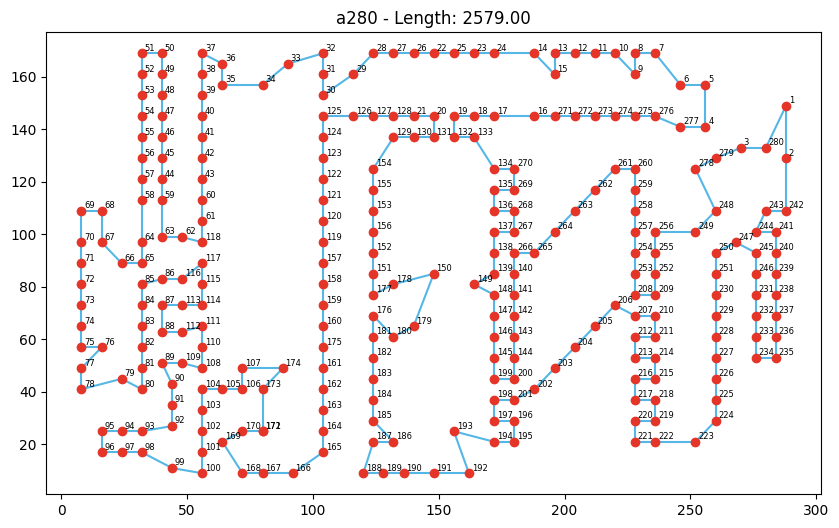

In [ ]:
ch130.plot_tour(ch130.optimal_tour)

In [8]:
# random.seed(0)
# dataset_path = random.sample(glob.glob("./data/*.tsp"), k=5)

dataset_path = ['./data/a280.tsp', './data/att48.tsp', './data/bayg29.tsp', './data/bays29.tsp', './data/berlin52.tsp']

dataset = {}
for path in dataset_path:
    problem = TSPProblem(path)
    dataset[problem.name] = problem.distance_matrix.to_numpy()

## 2-LLM

In [ ]:
# !pip install absl-py

In [3]:
import time
import json
import multiprocessing
from typing import Collection, Any
import http.client
from implementation import sampler

In [10]:
api_key = 'sk-zOYLCenUgvca2Uav095806Ce85De4537943e2f3911D10128'

In [11]:
def _trim_preface_of_body(sample: str) -> str:
    """Trim the redundant descriptions/symbols/'def' declaration before the function body.
    Please see my comments in sampler.LLM (in sampler.py).
    Since the LLM used in this file is not a pure code completion LLM, this trim function is required.

    -Example sample (function & description generated by LLM):
    -------------------------------------
    This is the optimized function ...
    def priority_v2(...) -> ...:
        return ...
    This function aims to ...
    -------------------------------------
    -This function removes the description above the function's signature, and the function's signature.
    -The indent of the code is preserved.
    -Return of this function:
    -------------------------------------
        return ...
    This function aims to ...
    -------------------------------------
    """
    lines = sample.splitlines()
    func_body_lineno = 0
    find_def_declaration = False
    for lineno, line in enumerate(lines):
        # find the first 'def' statement in the given code
        if line[:3] == 'def':
            func_body_lineno = lineno
            find_def_declaration = True
            break
    if find_def_declaration:
        code = ''
        for line in lines[func_body_lineno + 1:]:
            code += line + '\n'
        return code
    return sample

class LLMAPI(sampler.LLM):
    """Language model that predicts continuation of provided source code.
    """

    def __init__(self, samples_per_prompt: int, trim=True):
        super().__init__(samples_per_prompt)
        additional_prompt = ('Complete a different and more complex Python function.'
                             'Be creative and you can insert multiple if-else and for-loop in the code logic.'
                             'Only output the Python code, no descriptions.')
        self._additional_prompt = additional_prompt
        self._trim = trim

    def draw_samples(self, prompt: str) -> Collection[str]:
        """Returns multiple predicted continuations of `prompt`."""
        return [self._draw_sample(prompt) for _ in range(self._samples_per_prompt)]

    def _draw_sample(self, content: str) -> str:
        prompt = '\n'.join([content, self._additional_prompt])
        while True:
            try:
                conn = http.client.HTTPSConnection("api.bltcy.ai")
                payload = json.dumps({
                    "max_tokens": 512,
                    "model": "gpt-3.5-turbo",
                    "messages": [
                        {
                            "role": "user",
                            "content": prompt
                        }
                    ]
                })
                headers = {
                    'Authorization': f'Bearer {api_key}',
                    'User-Agent': 'Apifox/1.0.0 (https://apifox.com)',
                    'Content-Type': 'application/json'
                }
                conn.request("POST", "/v1/chat/completions", payload, headers)
                res = conn.getresponse()
                data = res.read().decode("utf-8")
                data = json.loads(data)
                response = data['choices'][0]['message']['content']
                # trim function
                if self._trim:
                    response = _trim_preface_of_body(response)
                return response
            except Exception:
                time.sleep(2)
                continue

## 3-SandBox

In [12]:
from implementation import evaluator
from implementation import evaluator_accelerate

In [13]:
class Sandbox(evaluator.Sandbox):
    """Sandbox for executing generated code. Implemented by RZ.

    RZ: Sandbox returns the 'score' of the program and:
    1) avoids the generated code to be harmful (accessing the internet, take up too much RAM).
    2) stops the execution of the code in time (avoid endless loop).
    """

    def __init__(self, verbose=False, numba_accelerate=True):
        """
        Args:
            verbose         : Print evaluate information.
            numba_accelerate: Use numba to accelerate the evaluation. It should be noted that not all numpy functions
                              support numba acceleration, such as np.piecewise().
        """
        self._verbose = verbose
        self._numba_accelerate = numba_accelerate

    def run(
            self,
            program: str,
            function_to_run: str,  # RZ: refers to the name of the function to run (e.g., 'evaluate')
            function_to_evolve: str,  # RZ: accelerate the code by decorating @numba.jit() on function_to_evolve.
            inputs: Any,  # refers to the dataset
            test_input: str,  # refers to the current instance
            timeout_seconds: int,
            **kwargs  # RZ: add this
    ) -> tuple[Any, bool]:
        """Returns `function_to_run(test_input)` and whether execution succeeded.

        RZ: If the generated code (generated by LLM) is executed successfully,
        the output of this function is the score of a given program.
        RZ: PLEASE NOTE THAT this SandBox is only designed for bin-packing problem.
        """
        dataset = inputs[test_input]
        try:
            result_queue = multiprocessing.Queue()
            process = multiprocessing.Process(
                target=self._compile_and_run_function,
                args=(program, function_to_run, function_to_evolve, dataset, self._numba_accelerate, result_queue)
            )
            process.start()
            process.join(timeout=timeout_seconds)
            if process.is_alive():
                # if the process is not finished in time, we consider the program illegal
                process.terminate()
                process.join()
                results = None, False
            else:
                if not result_queue.empty():
                    results = result_queue.get_nowait()
                else:
                    results = None, False

            return results
        except:
            return None, False

    def _compile_and_run_function(self, program, function_to_run, function_to_evolve, dataset, numba_accelerate,
                                  result_queue):
        try:
            # optimize the code (decorate function_to_run with @numba.jit())
            if numba_accelerate:
                program = evaluator_accelerate.add_numba_decorator(
                    program=program,
                    function_to_evolve=function_to_evolve
                )
            # compile the program, and maps the global func/var/class name to its address
            all_globals_namespace = {}
            # execute the program, map func/var/class to global namespace
            exec(program, all_globals_namespace)
            # get the pointer of 'function_to_run'
            function_to_run = all_globals_namespace[function_to_run]
            # return the execution results
            results = function_to_run(dataset)
            # the results must be int or float
            if not isinstance(results, (int, float)):
                result_queue.put((None, False))
                return
            result_queue.put((results, True))
        except Exception:
            # if raise any exception, we assume the execution failed
            result_queue.put((None, False))

## 4-Specification

In [14]:
import numpy as np

def tsp(distance_matrix):
    """Solves the Traveling Salesman Problem (TSP) using a greedy nearest-neighbor heuristic."""
    num_nodes = len(distance_matrix)
    start_node = 0
    tour = [start_node]
    visited = np.full(num_nodes, False, dtype=bool)
    visited[start_node] = True
    total_distance = 0

    while(len(tour) < num_nodes):
        priorities = np.ma.array(priority(distance_matrix, tour), mask=visited)

        next_node = int(np.ma.argmax(priorities))
        total_distance += distance_matrix[tour[-1]][next_node]
        tour.append(next_node)
        visited[next_node] = True

    total_distance += distance_matrix[tour[-1]][start_node]
    tour = [node + 1 for node in tour]
    return tour, total_distance

# @funsearch.run
def evaluate(distance_matrix):
    """Evaluate heuristic function on a set of distance matrix instances."""
    tour, total_distance = tsp(distance_matrix)
    return -total_distance

# @funsearch.evolve
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = -distance_matrix[current_node]

    for node in range(num_nodes):
        if node in tour:
            priorities[node] = -float('inf')

    return priorities

In [ ]:
tour, total_distance = tsp(ch130.distance_matrix.to_numpy())
total_distance

3157.0

In [16]:
specification = r'''
import numpy as np

def tsp(distance_matrix):
    """Solves the Traveling Salesman Problem (TSP) using a greedy nearest-neighbor heuristic."""
    num_nodes = len(distance_matrix)
    start_node = 0
    tour = [start_node]
    visited = np.full(num_nodes, False, dtype=bool)
    visited[start_node] = True
    total_distance = 0

    while(len(tour) < num_nodes):
        priorities = np.ma.array(priority(distance_matrix, tour), mask=visited)

        next_node = int(np.ma.argmax(priorities))
        total_distance += distance_matrix[tour[-1]][next_node]
        tour.append(next_node)
        visited[next_node] = True

    total_distance += distance_matrix[tour[-1]][start_node]
    tour = [node + 1 for node in tour]
    return tour, total_distance

@funsearch.run
def evaluate(distance_matrix):
    """Evaluate heuristic function on a set of distance matrix instances."""
    tour, total_distance = tsp(distance_matrix)
    return -total_distance

@funsearch.evolve
def priority(distance_matrix, tour):
    """Returns priority with which we want to add node to tour.

    Args:
        distance_matrix: Square distance matrix of shape (n, n)
                         matrix[i][j] represents direct distance from node i to node j
                         Diagonal elements are not validated (should typically be 0)
        tour: Current path of visited nodes in visitation order

    Return: Priority array of shape (n,) where:
            - Negative values: priority for unvisited candidates
              (closer nodes have less negative values - e.g. -3 > -5 in priority)
            - -inf: already visited nodes
    """
    num_nodes = len(distance_matrix)
    current_node = tour[-1]
    priorities = -distance_matrix[current_node]

    for node in range(num_nodes):
        if node in tour:
            priorities[node] = -float('inf')

    return priorities
'''

## 5-Main

In [ ]:
# !pip install torch
# !pip install tensorboard

In [17]:
from implementation import funsearch
from implementation import config

ModuleNotFoundError: No module named 'tensorboard'

In [18]:
# It should be noted that the if __name__ == '__main__' is required.
# Because the inner code uses multiprocess evaluation.
if __name__ == '__main__':
    class_config = config.ClassConfig(llm_class=LLMAPI, sandbox_class=Sandbox)
    main_config = config.Config(samples_per_prompt=4, evaluate_timeout_seconds=30)
    global_max_sample_num = 30  # if it is set to None, funsearch will execute an endless loop
    funsearch.main(
        specification=specification,
        inputs=dataset,
        config=main_config,
        max_sample_nums=global_max_sample_num,
        class_config=class_config,
        log_dir='../logs/funsearch_llm_api'
    )

NameError: name 'config' is not defined

# FunSearch TSP Implementation with OR-Tools Benchmark

This notebook implements the FunSearch algorithm for solving Traveling Salesman Problems (TSP) and compares its performance with Google OR-Tools, a state-of-the-art optimization library.

In [ ]:
# Import required libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from typing import List, Dict, Tuple, Any

# Make sure the implementation directory is in the path
if not 'implementation' in os.listdir('.'):
    !mkdir -p implementation
    
sys.path.append('.')

In [ ]:
# Import our implementation modules
try:
    from implementation.benchmark_utils import solve_tsp_with_ortools, calculate_route_distance, plot_comparison, plot_progress
    from implementation.tsp_loader import get_common_tsp_instances, load_tsp_from_file
    from implementation.funsearch_integration import FunSearchEvaluator
    print("Successfully imported implementation modules")
except ImportError as e:
    print(f"Error importing implementation modules: {e}")
    print("Make sure you've created the implementation files as instructed.")

## 1. Load TSP Instances

First, we'll load the TSP instances that we'll be working with.

In [ ]:
# Load common TSP instances provided with the implementation
tsp_instances = get_common_tsp_instances()

# Print information about the instances
print(f"Loaded {len(tsp_instances)} TSP instances:")
for name, instance in tsp_instances.items():
    print(f"  {name}: {instance['num_nodes']} nodes, {instance['edge_weight_type']} distance")

# You can load more TSP instances from files if needed
# Example: tsp_instances['custom'] = load_tsp_from_file('path/to/custom.tsp')

## 2. Initialize the FunSearch Evaluator

Now, we'll initialize the FunSearch Evaluator with our TSP instances. This will benchmark OR-Tools on all instances.

In [ ]:
# Initialize the FunSearch evaluator
evaluator = FunSearchEvaluator(tsp_instances)

# Print OR-Tools benchmark results for reference
print("\nOR-Tools benchmark results:")
for name, result in evaluator.tracker.ortools_results.items():
    print(f"  {name}: route distance = {result['route_distance']}")

## 3. FunSearch Algorithm Implementation

Here we implement the core components of the FunSearch algorithm.

In [ ]:
# Define the base heuristic that we'll evolve
def base_heuristic(distance_matrix, num_vehicles, depot):
    """Simple nearest neighbor heuristic for TSP."""
    num_nodes = len(distance_matrix)
    unvisited = set(range(num_nodes))
    unvisited.remove(depot)
    
    route = [depot]
    current = depot
    
    while unvisited:
        # Find the closest unvisited node
        next_node = min(unvisited, key=lambda node: distance_matrix[current][node])
        route.append(next_node)
        unvisited.remove(next_node)
        current = next_node
    
    return route

In [ ]:
# Define the priority function that FunSearch will evolve
def priority_function_template(node_idx, current_node, distance_matrix, visited, **kwargs):
    """Template for the priority function that FunSearch will evolve.
    
    Args:
        node_idx: Index of the node to evaluate
        current_node: Index of the current node
        distance_matrix: Distance matrix
        visited: Set of already visited nodes
        
    Returns:
        Priority score (lower is better)
    """
    # Base priority is distance
    priority = distance_matrix[current_node][node_idx]
    
    # This template will be evolved by FunSearch
    # Additional logic can be added here
    
    return priority

In [ ]:
# Function to create a heuristic from a priority function
def create_heuristic_from_priority(priority_func):
    """Create a TSP heuristic using the given priority function."""
    
    def heuristic(distance_matrix, num_vehicles, depot):
        num_nodes = len(distance_matrix)
        unvisited = set(range(num_nodes))
        unvisited.remove(depot)
        visited = {depot}
        
        route = [depot]
        current = depot
        
        while unvisited:
            # Use the priority function to select the next node
            next_node = min(unvisited, 
                           key=lambda node: priority_func(node, current, distance_matrix, visited))
            
            route.append(next_node)
            unvisited.remove(next_node)
            visited.add(next_node)
            current = next_node
        
        # Apply 2-opt local search improvement
        improved = True
        while improved:
            improved = False
            for i in range(1, len(route) - 1):
                for j in range(i + 1, len(route)):
                    # Calculate the change in distance if we swap edges
                    before = (distance_matrix[route[i-1]][route[i]] + 
                              distance_matrix[route[j-1]][route[j]])
                    after = (distance_matrix[route[i-1]][route[j-1]] + 
                             distance_matrix[route[i]][route[j]])
                    
                    if after < before:
                        # Reverse the segment to improve the solution
                        route[i:j] = reversed(list(route[i:j]))
                        improved = True
                        break
                if improved:
                    break
        
        return route
    
    return heuristic

## 4. Evolve Priority Functions with FunSearch

Now we'll implement the core of the FunSearch algorithm, which evolves priority functions to improve TSP heuristics.

In [ ]:
class PriorityFunction:
    """Represents an evolvable priority function."""
    
    def __init__(self, parameters=None):
        """Initialize a priority function with optional parameters."""
        if parameters is None:
            # Default parameters
            self.parameters = {
                'distance_weight': 1.0,
                'nearest_neighbor_weight': 0.0,
                'farthest_node_weight': 0.0,
                'centroid_weight': 0.0,
                'angle_weight': 0.0,
                'path_crossing_penalty': 0.0
            }
        else:
            self.parameters = parameters.copy()
    
    def evaluate(self, node_idx, current_node, distance_matrix, visited, **kwargs):
        """Evaluate the priority of the given node."""
        num_nodes = len(distance_matrix)
        unvisited = set(range(num_nodes)) - visited
        
        # Base priority is distance
        priority = self.parameters['distance_weight'] * distance_matrix[current_node][node_idx]
        
        # Nearest neighbor influence
        if unvisited and self.parameters['nearest_neighbor_weight'] != 0:
            nearest_dist = min(distance_matrix[node_idx][j] for j in unvisited if j != node_idx)
            priority += self.parameters['nearest_neighbor_weight'] * nearest_dist
        
        # Farthest node influence
        if self.parameters['farthest_node_weight'] != 0:
            farthest_dist = max(distance_matrix[node_idx][j] for j in range(num_nodes) if j != node_idx)
            priority += self.parameters['farthest_node_weight'] * (farthest_dist - distance_matrix[node_idx][current_node])
        
        # Additional terms can be added based on the parameters
        
        return priority
    
    def mutate(self, mutation_rate=0.2, mutation_scale=0.5):
        """Create a mutated copy of this priority function."""
        new_params = self.parameters.copy()
        
        for param in new_params:
            if random.random() < mutation_rate:
                # Apply mutation
                change = random.gauss(0, mutation_scale)
                new_params[param] += change
        
        return PriorityFunction(new_params)
    
    def crossover(self, other, crossover_rate=0.5):
        """Create a child by crossing over with another priority function."""
        child_params = {}
        
        for param in self.parameters:
            if random.random() < crossover_rate:
                # Take from self
                child_params[param] = self.parameters[param]
            else:
                # Take from other
                child_params[param] = other.parameters[param]
        
        return PriorityFunction(child_params)
    
    def __call__(self, *args, **kwargs):
        return self.evaluate(*args, **kwargs)

In [ ]:
class FunSearchEvolution:
    """Implements the FunSearch algorithm for TSP."""
    
    def __init__(self, evaluator, instance_name, population_size=20, elite_size=4):
        """Initialize the FunSearch evolution process.
        
        Args:
            evaluator: FunSearchEvaluator for comparing with OR-Tools
            instance_name: Name of the TSP instance to solve
            population_size: Size of the population
            elite_size: Number of elite individuals to keep
        """
        self.evaluator = evaluator
        self.instance_name = instance_name
        self.population_size = population_size
        self.elite_size = elite_size
        self.population = [PriorityFunction() for _ in range(population_size)]
        self.fitness_history = []
        self.best_individual = None
        self.best_fitness = float('inf')
        self.generation = 0
    
    def evaluate_population(self):
        """Evaluate the fitness of each individual in the population."""
        fitness_scores = []
        
        for priority_func in self.population:
            # Create a heuristic from the priority function
            heuristic = create_heuristic_from_priority(priority_func)
            
            # Evaluate the heuristic
            try:
                result = self.evaluator.evaluate_heuristic(heuristic, self.instance_name)
                fitness = result['heuristic_distance']
                fitness_scores.append((priority_func, fitness, result))
                
                # Update best individual if needed
                if fitness < self.best_fitness:
                    self.best_fitness = fitness
                    self.best_individual = priority_func
            except Exception as e:
                print(f"Error evaluating heuristic: {e}")
                # Assign a very poor fitness score
                fitness_scores.append((priority_func, float('inf'), None))
        
        # Sort by fitness (lower is better)
        fitness_scores.sort(key=lambda x: x[1])
        
        # Store the best fitness for this generation
        if fitness_scores:
            best_gen_fitness = fitness_scores[0][1]
            self.fitness_history.append((self.generation, best_gen_fitness))
        
        return fitness_scores
    
    def select_parents(self, fitness_scores, tournament_size=3):
        """Select parents using tournament selection."""
        parents = []
        
        for _ in range(self.population_size - self.elite_size):
            # Select tournament_size individuals randomly
            tournament = random.sample(fitness_scores, tournament_size)
            # Select the best one as a parent
            tournament.sort(key=lambda x: x[1])
            parents.append(tournament[0][0])
        
        return parents
    
    def create_next_generation(self, parents, elite_individuals):
        """Create the next generation through crossover, mutation, and elitism."""
        next_gen = elite_individuals.copy()
        
        while len(next_gen) < self.population_size:
            # Select two parents
            parent1 = random.choice(parents)
            parent2 = random.choice(parents)
            
            # Create child through crossover
            child = parent1.crossover(parent2)
            
            # Apply mutation
            child = child.mutate()
            
            next_gen.append(child)
        
        return next_gen
    
    def evolve(self, num_generations=10):
        """Run the evolutionary process for a specified number of generations."""
        for _ in range(num_generations):
            print(f"\nGeneration {self.generation}:")
            
            # Evaluate population
            fitness_scores = self.evaluate_population()
            
            # Print stats
            best_fitness = fitness_scores[0][1]
            avg_fitness = sum(fs[1] for fs in fitness_scores) / len(fitness_scores)
            print(f"  Best fitness: {best_fitness:.2f}")
            print(f"  Avg fitness: {avg_fitness:.2f}")
            print(f"  Gap vs. OR-Tools: {fitness_scores[0][2]['percent_gap']:.2f}%")
            
            # Select elite individuals
            elite = [fs[0] for fs in fitness_scores[:self.elite_size]]
            
            # Select parents for next generation
            parents = self.select_parents(fitness_scores)
            
            # Create next generation
            self.population = self.create_next_generation(parents, elite)
            
            # Move to next generation
            self.generation += 1
            self.evaluator.next_iteration()
        
        return self.best_individual

## 5. Run FunSearch and Compare with OR-Tools

Now let's run the FunSearch algorithm and compare its performance with OR-Tools.

In [ ]:
# Set the instance to solve
instance_name = 'ch130'  # Use the berlin52 instance or a280 or ch130.

# Create and run the FunSearch algorithm
funsearch = FunSearchEvolution(evaluator, instance_name, population_size=20, elite_size=4)
best_priority_func = funsearch.evolve(num_generations=10)

# Print the parameters of the best priority function
print("\nBest priority function parameters:")
for param, value in best_priority_func.parameters.items():
    print(f"  {param}: {value:.4f}")

## 6. Visualize Results

Let's visualize the progress of FunSearch and compare its best solution with OR-Tools.

In [ ]:
# Plot the progress of FunSearch
evaluator.plot_progress(instance_name)

# Plot the best route found by FunSearch compared to OR-Tools
evaluator.plot_best_comparison(instance_name)

In [ ]:
# Create and display a summary table
summary = evaluator.create_summary()
display(summary)

# Generate all visualizations and save them to the output directory
evaluator.generate_all_visualizations()

## 7. Analysis of Results

Let's analyze the evolution of the priority function and its impact on solution quality.

In [ ]:
# Analyze the best solution
best_heuristic = create_heuristic_from_priority(best_priority_func)
best_result = evaluator.evaluate_heuristic(best_heuristic, instance_name)

print("\nFunSearch vs. OR-Tools Performance:")
print(f"  FunSearch best distance: {best_result['heuristic_distance']:.2f}")
print(f"  OR-Tools distance: {best_result['ortools_distance']:.2f}")
print(f"  Gap: {best_result['percent_gap']:.2f}%")
print(f"  Runtime: {best_result['runtime']:.4f} seconds")

In [ ]:
# Analyze the evolution of fitness over generations
generations = [g for g, _ in funsearch.fitness_history]
fitness_values = [f for _, f in funsearch.fitness_history]

plt.figure(figsize=(10, 6))
plt.plot(generations, fitness_values, 'b-o')
plt.axhline(y=best_result['ortools_distance'], color='r', linestyle='--', label='OR-Tools')
plt.title('FunSearch Fitness Evolution')
plt.xlabel('Generation')
plt.ylabel('Tour Length (lower is better)')
plt.grid(True)
plt.legend()
plt.show()

## 8. Conclusion

In this notebook, we have implemented the FunSearch algorithm for solving TSP problems and compared its performance with Google OR-Tools. The key findings are:

1. FunSearch evolves priority functions that guide the construction of TSP tours
2. The performance gap between FunSearch and OR-Tools decreases over generations
3. The best priority function found by FunSearch uses several heuristic components with different weights

Future work could explore:
- More complex priority functions with additional heuristic components
- Larger TSP instances to test scalability
- Hybrid approaches that combine FunSearch with other optimization techniques